This ipython notebook was first developed before the database was set up, so there is the option to load multiple flat files into a combined file and perform analysis on this. 

However, it can also be used with files obtained from database queryies and their associated classification vectors.

The following functions are included:
1. Clean dataset - remove low quality genes and cells
2. PCA
3. Gene subsetting - either Select k- best OR manually insert a list of genes of interest OR use PCA on full dataset to obtain 
   a subset of PCs to use for visualization
4. Plot the cv-squared over mean for all genes in a subset
5. TSNE (on gene subset or PCAs) + plot
6. ZIFA + plot


In [66]:
# activiate inline plotting
%pylab inline
# load modules
import pandas as pd
from sklearn import svm, cross_validation, feature_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition.pca import PCA
import os
import json
import sys
from datetime import datetime
from sklearn import manifold
from scipy import stats
import seaborn as sns
from ZIFA import ZIFA
#from ZIFA import block_ZIFA

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


All output files will be sent to the specified analysis directory

In [67]:
#specify the input directory containing your original data and classification file
analysis_directory = "C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\DropseqViewer\\analysis\\lupus_PvNID"
#specify the prefix directory at which new files will be saved (generally the same as the analysis_directory)
prefix = "C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\DropseqViewer\\analysis\\lupus_PvNID"

classification_json = {} #declare global variable 

DECLARE FUNCTIONS
*this is something that could be moved to an outside module and imported for use in the ipython notebook (TODO)

In [68]:
#remove GENES that do not meet the specified threshold
def removeRows(df, threshold):
    df_no_under_ten = df.loc[(df.sum(axis=1) >= threshold)] #remove all rows that have sum < 10
    #print("completed removal of genes(rows): (threshold = "+ str(threshold) +")  -  " + str(datetime.now() - startTime))
    #print(df_no_under_ten.shape)
    return df_no_under_ten

#remove CELLS that do not meet the specified threshold
def removeCols(df, threshold):
    df_no_col_under_twothousand = df.loc[:,(df.sum(axis=0) >= threshold)]
    #print("completed removal of cells(columns): (threshold = "+ str(threshold) +")  -  " + str(datetime.now() - startTime))
    #print(df_no_col_under_twothousand.shape)
    return df_no_col_under_twothousand

def viewGeneExpnDistribution(df):
    #distribution of reads/gene
    cells_containing_each_gene = []
    total_transcripts_per_gene = []
    variance_trancripts_per_gene = []
    for i in df.index:
        count = 0
        sum = 0
        variance = []
        for cell in df.loc[[i]]:
            x = df.loc[i,cell]
            print("i: " + i)
            print("cell: " + cell)
            print("X: " +str(x))
            if x > 0:
                count +=1
                sum += x
                variance.append(x)
        cells_containing_each_gene.append(count)
        total_transcripts_per_gene.append(sum)
        variance_trancripts_per_gene.append(np.var(variance))


    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    pd.Series(total_transcripts_per_gene).plot(kind='hist',color="#19194d", alpha=.75, 
                                               ax=axs[0],title="Distribution of Transcript Counts per Gene")
    pd.Series(cells_containing_each_gene).plot(kind='hist', color="#2bf60b", alpha=.75, 
                                               ax=axs[1],title="Distribution of # of Cells Containing Gene X")
    
    #plt.title("Distribution of Transcript Count per Gene")

#TODO:
#consider adding more distribution plots 
#(from code in investigateGeneVariance.py and/or plotGeneExprDistribution.py)

Create a Joint pandas DataFrame from in specified input files. This will simultaneously generate a classification vector, append it to the dataframe, and apply row and column thresholds, and then remove the classification vector from the raw dataframe. The classification vector will be saved for use in the d3pipeline_1.py.

In [ ]:
# create joint DF file

# load in the dropseq data - pre-normalized file (per dropseq_1.py)
#IF1, IF2
DF1a = pd.read_csv(os.path.join(prefix,"P-19_S9_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)
DF1b = pd.read_csv(os.path.join(prefix,"P-25_S11_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)
DF1c = pd.read_csv(os.path.join(prefix,"P-27_S12_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)

#DF2 = pd.read_csv(os.path.join(prefix,"PF-25_S13_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)
#DF2b = pd.read_csv(os.path.join(prefix,"PW-25_S14_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)
#DF2c = pd.read_csv(os.path.join(prefix,"PW-27_S15_L007_R1_001_matrix_normalized.txt"),sep="\t", index_col=0)
#DF2 = pd.read_csv(os.path.join(prefix,"NID0157_dsq_2_S4_R1_matrix_normalized.txt"), sep="\t", index_col=0)
#combining = [DF1a, DF1b, DF1c,DF2a, DF2b, DF2c]

DF2a = pd.read_csv(os.path.join(prefix,"NID0194_dsq_1_S2_R1_matrix_normalized.txt"),sep="\t", index_col=0)
DF2b = pd.read_csv(os.path.join(prefix,"NID0194_dsq_2_S3_R1_matrix_normalized.txt"),sep="\t", index_col=0)
DF2c = pd.read_csv(os.path.join(prefix,"NID0157_dsq_1_S1_R1_matrix_normalized.txt"),sep="\t", index_col=0)
DF2d = pd.read_csv(os.path.join(prefix,"NID0157_dsq_2_S4_R1_matrix_normalized.txt"),sep="\t", index_col=0)

DF1 = pd.concat([DF1a,DF1b,DF1c], axis = 1)
DF2 = pd.concat([DF2a,DF2b,DF2c,DF2d], axis = 1)
combining = [DF1, DF2]
DF = pd.concat([DF1,DF2], axis=1)

classification = []
count = 0
for c in combining:
    count +=1 
    temp = classification + [count*100]*len(c.columns.values)
    classification = temp

#add the classification to the dataframe so that it can be modified during removal of cols and rows
DF.loc[len(DF)]=classification
df_with_class = DF

#save classification for use with d3pipeline.py
classification_json["classification"] = classification
#print(classification)
json.dump(classification_json, open(os.path.join(analysis_directory, "classification.json"),'w') )

Create a single pandas Dataframe from a single specified input file...
1. in the case when we are not doing comparative analysis
2. in the case where we used the database to select/combine cells and write them to a file

In [73]:
# load the dropseq data from a single file
DF1 = pd.read_csv(os.path.join(prefix,"lupus_combinedL4.csv"),sep=",", index_col=0)

# load the classification (manually or from a file)
#classification = [100]*len(DF1.columns.values)
#classification_lupusPvNID = [200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,13]
#vvv full lupus PvNID classification 4/18
classification = [700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300]

DF = DF1.transpose()

print(DF.shape)
print(len(classification))

#add the classification to the dataframe so that it can be modified during removal of cols and rows
DF.loc[len(DF)]=classification
df_with_class = DF

#save classification for use with d3pipeline.py
classification_json["classification"] = classification
json.dump(classification_json, open(os.path.join(analysis_directory, "classification.json"),'w') )

(25345, 3831)
3831


Apply Filters!

In [75]:
# remove the classification vector from the filtered data
DF_final = DF[:-1] #this will return all rows except for the last one
final_class = []
for i in DF.tail(1).as_matrix()[0]:
    final_class.append(i)

classification_json["final_classification"] = final_class 
#json.dump(classification_json, open(os.path.join(analysis_directory, "classification.json"),'w') )

In [74]:
# filter the data
print(DF.shape)
DF = removeRows(removeCols(df_with_class, 50000), 90000) #These thresholds may need to be updated based \
                                                    #on the total number of cells in combined file
    
print(DF.shape)
# save the filtered dataframe to file
DF.to_csv(os.path.join(prefix,"smallerDF.txt"),sep="\t")

(25346, 3831)
(6672, 3831)


In [63]:
# run PCA
pca = PCA(n_components=15)
pcaF = pca.fit(subset_df)#DF_final)
print(pcaF)

#print(pca.components_)
#print(shape(pca.components_))

PCA(copy=True, n_components=15, whiten=False)
PCA(copy=True, n_components=15, whiten=False)


In [1]:
# plot the gene expression distribution inline
#print(DF_final)
viewGeneExpnDistribution(DF_final)
print("Total Number of Cells Remaining: " + str(len(DF_final.columns.values)))
print("Total Number of Genes Remaining: " + str(len(DF_final.index)))

NameError: name 'viewGeneExpnDistribution' is not defined

In [49]:
# select the k-best genes (essentially a chi-squared test), subset the dataframe to contain only those genes, save the subset

print("selecting k best")
DFt = DF_final.transpose()
sample_classification = classification_json["final_classification"]

# select k best - TODO: Look up how this algorithm works behind the scenes
X_new = feature_selection.SelectKBest(feature_selection.chi2, k=1000).fit_transform(DFt, sample_classification)
n = feature_selection.SelectKBest(feature_selection.chi2,k=1000).fit(DFt, sample_classification)

t = n.get_support()
indices_of_interest = [i for i, x in enumerate(t) if x]
genes_of_interest = []

print("obtaining genes of interest")
for i in indices_of_interest:
    genes_of_interest.append(DFt.columns.values[i])

print(genes_of_interest)
subset_df = DF_final[DF_final.index.isin(genes_of_interest)]
subset_df.to_csv(os.path.join(prefix,"genesubsetDF.txt"),sep="\t")
#print("writing subset dataframe to file")
#subset_df.to_csv("C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\Data\\Lupus_data\\" + "_df_result.tsv",sep="\t")


selecting k best
SelectKBest(k=1000, score_func=<function chi2 at 0x00000000091DABF8>)
[0, 1, 2, 5, 6, 8, 9, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 57, 59, 60, 61, 62, 63, 64, 68, 70, 71, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 140, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 155, 157, 158, 159, 160, 161, 162, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 247, 248, 249, 250, 251, 254, 255, 260,

In [16]:
# optionally, manually insert a set of genes to use (instead of taking the k-best genes)
genes_of_interest = ['ACTB','ACTG1','ACTR2','ALAS2','CA1','CD4','CD69','CDK6','CHD1','CX3CR1','DYNLT1','EIF2AK2','FOS','GIMAP7','H3F3B','HBA1','HBA2','HBB','HBD','HBG1','HBG2','HIF1A','HLA-C','HOPX','IFI27','IFI44L','IFI6','IKZF3','IL7R','ITGB1','JUN','KLRB1','KLRF1','MIR6723','MS4A1','MTRNR2L5','MX1','NFKBIZ','PABPC1','PDE4D','PTPRC','RALGPS2','RPS26','RPS26P11','SLC25A36','SNCA','SRSF5','TNFAIP8','YBX3','YWHAZ']

subset_df = DF_final[DF_final.index.isin(genes_of_interest)]
subset_df.to_csv(os.path.join(prefix,"genesubsetDF.txt"),sep="\t") #save the subset dataframe

R-squared: 0.799949340963


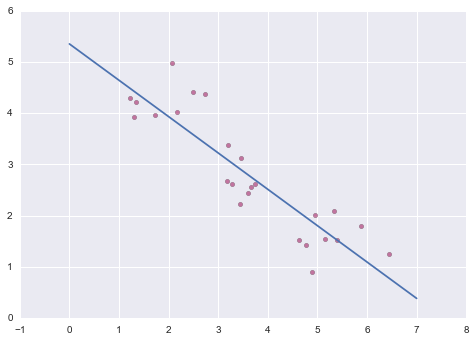

In [46]:
# Plot the cv-squared over mean for all genes in the gene set - this metric is commonly used to select genes for 
# Differential Expression Analysis. This is actually just viewing the distribution and not selecting based on it.

DEDF = subset_df#DF_final
means = np.mean(DEDF, axis=1) #row (gene) means #means <- rowMeans(ed)
vars = np.var(DEDF, axis=1) #row (gene) variances #vars <- apply(ed,1,var)
cv2 = np.asarray(vars)/np.asarray(([i ** 2 for i in list(means)])) #cv2 <- vars/means^2
x=np.log(means)
y=np.log(cv2)
plt.scatter(x,y,c="#99004d", alpha = 0.5)

axes = plt.gca()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("R-squared: " + str(r_value**2))
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot,slope*X_plot+intercept,'-')   


In [ ]:
# run annova test (?) !!! only if comparing two datasets, COMPUTATIONALLY INTENSIVE !!!
# return 20 best

541
15
begin tSNE
completed tSNE


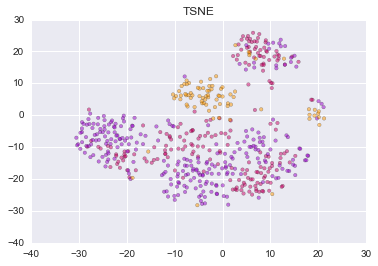

In [65]:
# run TSNE 

#X = subset_df.transpose() #DF_final.transpose()
X = (pca.components_).transpose()
#X = (Z_trans)
n_samples, n_features = X.shape[0],X.shape[1]
print(n_samples)
print(n_features)
print("begin tSNE")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
# plot the result
vis_x = X_tsne[:,0]
vis_y = X_tsne[:,1] #1]
print("completed tSNE")

# plot TSNE

color_options = ["#ff9900","#cc0066","#9900cc"]
#color_options = ["#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff"]
color=[]
for i in classification_json["classification"]:
    color.append(color_options[int((i/100)-1)])

area = np.pi *(2)**2 
plt.scatter(vis_x,vis_y, s=area, c=color, alpha = 0.5)# c="#ff9900", alpha=0.5)
plt.title("TSNE")


In [50]:
# run ZIFA
# https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0805-z
# https://github.com/epierson9/ZIFA

f = lambda x: np.log(1+x)
logDF = subset_df.applymap(f) #DF_final.applymap(f) #
#logDF = DF_final.applymap(f)

#Z, model_params = block_ZIFA.fitModel(logDF.as_matrix(), 2)
#Z, model_params = ZIFA.fitModel(logDF.as_matrix(), 2)

transposed_ZIFA = logDF.transpose()
Z_trans, MP_trans = ZIFA.fitModel(transposed_ZIFA.as_matrix(),15)

print('ZIFA finished')


Running zero-inflated factor analysis with N = 541, D = 1000, K = 15
Param change below threshold 1.000e-02 after 39 iterations
ZIFA finished


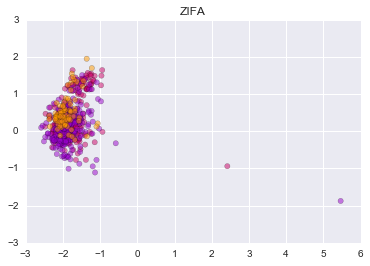

In [51]:
# plot ZIFA
color_options = ["#ff9900","#cc0066","#9900cc"]
color=[]
for i in classification_json["final_classification"]:
    color.append(color_options[int((i/100)-1)])

area = np.pi *(3)**2 
X=[]
Y=[]
for i in Z_trans:
    X.append(i[0])
    Y.append(i[1])
    
#print(X)
#print(Y)

plt.scatter(X,Y, s=area, alpha=0.5, c=color)#"#cc0066")
plt.title("ZIFA")

In [63]:
# run scLVM on it 
# example: http://nbviewer.jupyter.org/github/pmbio/scLVM/blob/master/tutorials/tcell_demo.ipynb,
# since I will have no spike-ins: https://github.com/PMBio/scLVM/blob/master/R/scripts/transform_counts_demo_no_spikeins.Rmd 

In [ ]:
# run monocle or D3E